In [142]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import numpy as np

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

In [143]:
class Collector(Agent):
    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.random.seed(12345)
        self.has_food = False
        self.type = "collector"

    def step(self) -> None:
        """
        Step function for the agent
        """

        self.move_to_food()
        self.move_to_storage()

    def move_to_food(self) -> None:
        """
        Moves the agent to the food location
        """

        if self.ready_to_pick() == False:
            return

        target = self.find_closest_food()
        neighborhood = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False,
            radius=1
        )

        if target in neighborhood:
            self.pick_food()
            return

        self.move(target, neighborhood)

    def move_to_storage(self) -> None:
        """
        Moves the agent to the storage location
        """

        if not self.ready_to_drop():
            return

        target = self.model.known_storage_location

        neighborhood = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False,
            radius=1
        )

        if target in neighborhood:
            self.drop_food()
            return

        self.move(target, neighborhood)

    def pick_food(self) -> None:
        """
        Pick food at the current location if the agent is ready to pick food
        """
        for i in range (self.model.grid.width):
            for j in range (self.model.grid.height):
                if self.model.known_food_layer[i][j] == 1:
                    self.model.known_food_layer[i][j] = 0
                    self.model.food_layer[i][j] = 0
                    self.has_food = True
                    return

    def drop_food(self) -> None:
        """"
        Drop food at the storage location
        """

        self.has_food = False
        self.model.storaged_food += 1

    def move(self, target: tuple, neighborhood: tuple) -> None:
        """
        Moves the agent
        """

        x = target[0] - self.pos[0]
        y = target[1] - self.pos[1]

        x = 1 if x > 0 else -1 if x < 0 else 0
        y = 1 if y > 0 else -1 if y < 0 else 0

        # Check if the new position is within the grid
        if self.pos[0] + x < 0 or self.pos[0] + x >= self.model.grid.width:
            x = 0
        if self.pos[1] + y < 0 or self.pos[1] + y >= self.model.grid.height:
            y = 0

        # Choose a new position closer to the target
        new_pos = (self.pos[0] + x, self.pos[1] + y)
        cellmate = self.model.grid.get_cell_list_contents(new_pos)

        max_tries = 10
        while cellmate:
            new_pos = self.random.choice(neighborhood)
            cellmate = self.model.grid.get_cell_list_contents(new_pos)
            max_tries -= 1
            if max_tries == 0:
                return

        self.model.grid.move_agent(self, new_pos)
        self.pos = new_pos

    # Helpers
    def find_closest_food(self) -> None:
        """
        Find the closest food location

        Returns:
            None
        """

        food_positions = []

        for i in range (self.model.grid.width):
            for j in range (self.model.grid.height):
                if self.model.known_food_layer[i][j] == 1:
                    food_positions.append((i,j))

        closest_food = None
        closest_distance = 1000000

        for food_position in food_positions:
            distance = self.distance_to(food_position)
            if distance < closest_distance:
                closest_food = food_position
                closest_distance = distance

        return closest_food

    def distance_to(self, position: tuple) -> int:
        """
        Find the distance to a position

        Args:
            position (tuple): The position to find the distance to

        Returns:
            int: The distance to the position
        """

        return abs(self.pos[0] - position[0]) + abs(self.pos[1] - position[1])

    def storage_found(self) -> bool:
        """
        Check if the agent has found the storage location

        Returns:
            bool: True if the agent has found the storage location, False otherwise
        """

        return self.model.known_storage_location is not None

    def ready_to_pick(self) -> bool:
        """
        Check if the agent is ready to pick food. Agent is ready to pick if:
        - There is food in the food layer
        - The agent does not have food
        - The storage location is found

        Returns:
            bool: True if the agent is ready to pick food, False otherwise
        """

        food_found = np.sum(self.model.known_food_layer)
        return food_found > 0 and not self.has_food and self.storage_found()

    def ready_to_drop(self) -> bool:
        """
        Check if the agent is ready to drop food. Agent is ready to drop if:
        - The agent has food
        - The storage location is found

        Returns:
            bool: True if the agent is ready to drop food, False otherwise
        """

        return self.has_food and self.storage_found()

In [144]:
class Explorer(Agent):
    RANDOM_SEED = 12345

    def __init__(self, unique_id: int, model: Model) -> None:
        """
        Initializes a new instance of the agent

        Args:
            unique_id (int): Unique identifier of the agent
            model (Model): Model in which the agent is instantiated
        """

        super().__init__(unique_id, model)
        self.random.seed(self.RANDOM_SEED)
        self.type = "explorer"

        self.visited = set()
        self.direction = "right"

    def move(self) -> None:
        """
        Moves the agent in a random walk, prioritizing unvisited cells.
        """
        neighbors = self.model.grid.get_neighborhood(
                    self.pos, moore=True, include_center=False
                )
        unvisited_neighbors = [
            cell
            for cell in neighbors
            if cell not in self.visited and self.model.grid.is_cell_empty(cell)
        ]

        if unvisited_neighbors:
            new_pos = self.random.choice(unvisited_neighbors)
        else:
            empty_neighbors = [
                cell for cell in neighbors if self.model.grid.is_cell_empty(cell)
            ]
            if empty_neighbors:
                new_pos = self.random.choice(empty_neighbors)
            else:
                return  # No move if no empty cells are available*

        self.model.grid.move_agent(self, new_pos)
        self.visited.add(new_pos)

    def find_food(self) -> None:
        """
        Look for food in the neighboring cells and mark it in the known food layer.
        """
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=True
        )
        for x, y in neighbors:
            if self.model.food_layer[x][y] > 0:
                self.model.known_food_layer[x][y] = 1

    def find_storage(self) -> None:
        """
        Look for storage in the neighboring cells and mark it in the known storage layer.
        """

        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=True
        )
        for x, y in neighbors:
            if self.model.storage_location == (x, y):
                self.model.known_storage_location = (x, y)

    def step(self) -> None:
        """
        Step through the environment.
        """

        self.move()
        self.find_food()
        self.find_storage()

In [145]:
def get_positions(model: Model):
    return np.asarray([agent.pos for agent in model.schedule.agents])

In [146]:
class NomNomModel(Model):
    RANDOM_SEED = 12345

    __slots__ = (
        "schedule",
        "grid",
        "running",
        "food_layer",
        "known_food_layer",
        "storage_location",
        "datacollector",
    )

    def __init__(self, width: int, height: int, num_agents=5, max_food=47) -> None:
        """
        Initializes the model with the given parameters.

        Args:
            width (int): The width of the grid.
            height (int): The height of the grid.
            num_agents (int): The number of agents to be created.
            max_food (int): The maximum amount of food to be created.
        """

        self.random.seed(self.RANDOM_SEED)

        # Data Collector
        self.datacollector = DataCollector(
            {
                "Food": lambda m: np.sum(m.food_layer),
                "Known Food": lambda m: np.sum(m.known_food_layer),
                "Agents": lambda m: m.schedule.get_agent_count(),
                "Agent Positions": get_positions,
                "Warehouse location": lambda m: m.storage_location,
            }
        )

        self.schedule = SimultaneousActivation(self)
        self.grid = SingleGrid(width, height, False)
        self.running = True
        self.total_food_spawned = 0

        # Layers
        self.init_food_layer = np.zeros((width, height), dtype=np.int8)
        self.food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_storage_location = None
        self.storage_location = None
        self.storaged_food = 0
        self.num_food = max_food

        # Model Instances
        self.spawn_agents(3, Collector, "collector_")
        self.spawn_agents(2, Explorer, "explorer_")
        self.place_warehouse()

    def spawn_agents(
        self, num_agents: int, agent_class: Agent, prefix: str = ""
    ) -> None:
        """
        Spawns the agents in random places of the grid.

        Args:
            num_agents (int): The number of agents to be created.
            agent_class (Agent): The class of the agent to be created.
        """

        used_positions = set()

        for i, _ in enumerate(range(num_agents)):
            while True:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)

                if (x, y) not in used_positions and self.grid.is_cell_empty((x, y)):
                    agent = agent_class((prefix, i), self)
                    self.grid.place_agent(agent, (x, y))
                    self.schedule.add(agent)

                    used_positions.add((x, y))
                    break

    def spawn_food(self, max_food: int) -> None:
        """
        Spawns the food in random places of the grid between 2 to 5 cells with
        one food item. The interval between the spawns is 5 steps.

        Args:
            max_food (int): The maximum amount of food to be created.
        """

        available_cells = [
            (x, y)
            for x in range(self.grid.width)
            for y in range(self.grid.height)
            if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0 and (x, y) != self.storage_location
        ]
        num_food = min(
            self.random.randrange(2, 6),
            max_food - self.total_food_spawned,
            len(available_cells),
        )

        for _ in range(num_food):
            x, y = self.random.choice(available_cells)
            self.food_layer[x][y] = 1
            self.init_food_layer[x][y] = 1
            self.total_food_spawned += 1
            available_cells.remove((x, y))

    def place_warehouse(self) -> None:
        """
        Places the warehouse in the center of the grid.
        """

        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0:
                self.storage_location = (x, y)
                break

    def step(self) -> None:
        """
        Advances the model by one step. Spawns the food each 5 steps
        """

        self.schedule.step()
        self.datacollector.collect(self)

        # Spawn food each 5 steps
        if self.schedule.steps % 5 == 0:
            self.spawn_food(self.num_food)

# Simulation Parameters

The simulation can be adjusted by changing the parameters in the cell below.

- **num_agents (int)**: The number of agents in the simulation.
- **max_food (int)**: The maximum amount of food that spawns in the simulation.
- **grid_size (int)**: The size of the grid in the simulation (grid_size x grid_size).
- **food_spawn_interval (int)**: The interval at which food spawns in the simulation.
- **min_food_per_spawn (int)**: The minimum amount of food that spawns in the simulation.
- **max_food_per_spawn (int)**: The maximum amount of food that spawns in the simulation.


In [147]:
NUM_AGENTS = 5
MAX_FOOD = 47
GRID_SIZE = 20

FOOD_SPAWN_INTERVAL = 5
MIN_FOOD_PER_SPAWN = 2
MAX_FOOD_PER_SPAWN = 5
ITERATIONS = 1500

In [148]:
def plot_simulation(model: NomNomModel, title: str, figsize=(10, 10), cmap="binary") -> None:
    """
    Plots the simulation grid.

    Args:
        model (NomNomModel): The model to be plotted.
        title (str): The title of the plot.
        figsize (tuple, optional): The size of the figure. Defaults to (10, 10).
        cmap (str, optional): The color map to be used. Defaults to "binary".
    """

    data = model.food_layer.copy()

    plt.figure(figsize=figsize)
    heatmap = plt.imshow(data, cmap=cmap)

    # Warehouse location
    warehouse_x, warehouse_y = model.storage_location
    plt.scatter(warehouse_y, warehouse_x, color="black", marker="s", s=50, label="Warehouse")

    food_layer = model.init_food_layer
    for i in range(len(food_layer)):
        for j in range(len(food_layer[0])):
            box_color = "black" if food_layer[i][j] > 0 else "blue"

            plt.text(j, i, food_layer[i][j], ha="center", va="center", color=box_color)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", bbox_to_anchor=(1, 1), fontsize=12)
    plt.xlabel("aisle", fontsize=14)
    plt.ylabel("shelf", fontsize=14)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    plt.show()

In [149]:
def anim_simulation(model: NomNomModel) -> None:
    """
    Animartes the simulation grid.

    Args:
        model (NomNomModel): The model to be plotted.
    """

    all_positions = model.datacollector.get_model_vars_dataframe()
    agent_pos = all_positions["Agent Positions"]

    warehouse_x, warehouse_y = model.storage_location

    fig, ax = plt.subplots(figsize=(3, 3))
    plt.close()
    scatter = ax.scatter(agent_pos[0][:,0], agent_pos[0][:,1], s=10, edgecolor="k")
    ax.scatter(warehouse_x, warehouse_y, color="black", marker="s", s=10, label="Warehouse")
    ax.axis([0, 20, 0, 20])

    def animate(i):
        scatter.set_offsets(agent_pos[i])

        return scatter

    anim = animation.FuncAnimation(fig, animate, frames = model.schedule.steps)
    return anim

In [150]:
def run_simulation() -> Model:
    """
    Runs the simulation.
    """

    model = NomNomModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, MAX_FOOD)

    for _ in range(ITERATIONS):
        model.step()
        if model.storaged_food == MAX_FOOD:
            print(f"Simulation finished in {model.schedule.steps} steps")
            break
    return model

In [151]:
def get_data(model):
    all_positions = model.datacollector.get_model_vars_dataframe()

    storage_location = model.storage_location
    agent_pos = all_positions["Agent Positions"]
    food_positions = model.init_food_layer

    return {
        "storage_location": storage_location,
        "agent_pos": agent_pos,
        "food_positions": food_positions,
    }

In [152]:
model = run_simulation()

Simulation finished in 292 steps


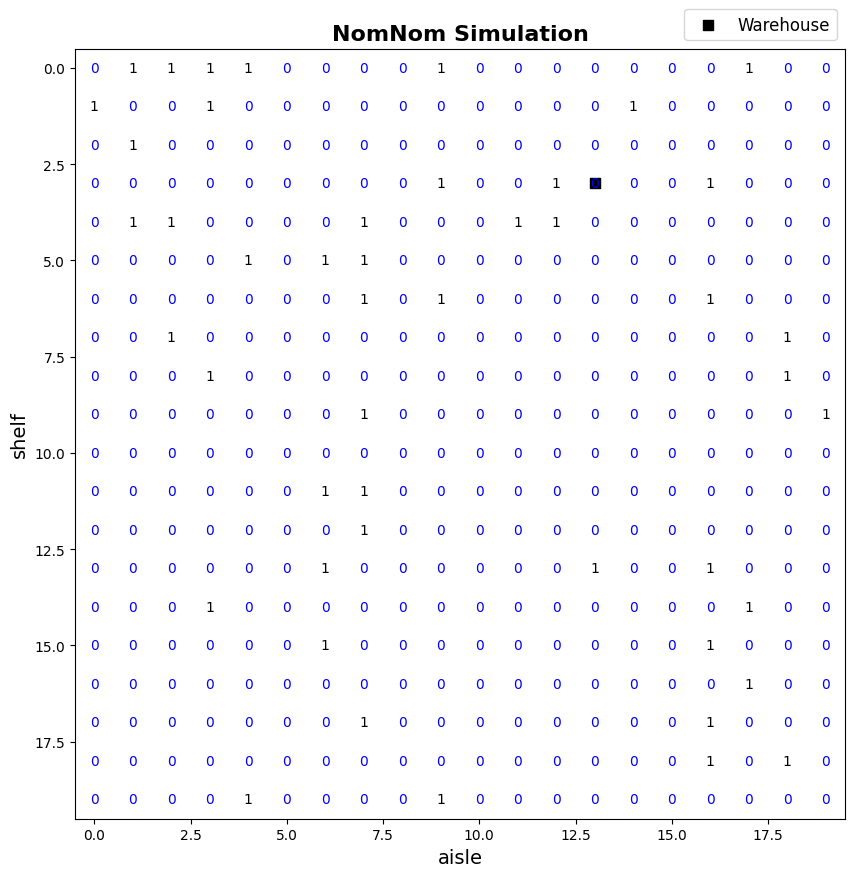

In [153]:
plot_simulation(model, "NomNom Simulation")

In [154]:
anim = anim_simulation(model)

In [155]:
anim